# DINOv3 + U-Net for Pixel-Level Lake Segmentation

This notebook shows how to:
1. Use DINOv3 as a feature extractor (frozen backbone)
2. Add a U-Net decoder for pixel-level segmentation
3. Train on your manual lake masks
4. Get precise lake boundaries (not just patch-level predictions)

**Key difference from previous approach:**
- Previous: 224x224 patch → single prediction ("has lake")
- This: 224x224 patch → 224x224 mask (pixel-level "which pixels are lake")

## Step 1: Setup and Imports

In [ ]:
# Core libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import rasterio

# Deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# DINOv3
from transformers import Dinov2Model, Dinov2Config
from huggingface_hub import login

# Login (you already have this)
login(token="login token")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Step 2: Load Your Data

In [14]:
# Load your satellite image and mask
image_path = "/Users/varyabazilova/Desktop/glacial_lakes/super_lakes/dinov3_tryout/test_data/2021-09-04_fcc_testclip2.tif"
mask_path = "/Users/varyabazilova/Desktop/glacial_lakes/super_lakes/dinov3_tryout/test_data/lake_mask_testclip2.tif"

with rasterio.open(image_path) as src:
    image = src.read()  # Shape: (channels, height, width)
    image = np.transpose(image, (1, 2, 0))  # Change to (height, width, channels)
    
with rasterio.open(mask_path) as src:
    mask = src.read(1)  # Read first band

print(f"Image shape: {image.shape}")
print(f"Mask shape: {mask.shape}")

# Convert to 0-255 range for neural networks
image_rgb = image[:,:,:3].astype(np.uint8)
mask_binary = (mask > 0).astype(np.float32)  # Binary mask for training

Image shape: (4673, 1362, 4)
Mask shape: (4673, 1362)


## Step 3: Create Training Dataset

In [15]:
class SmartLakeSegmentationDataset(Dataset):
    """
    Dataset that intelligently samples patches with lakes for training
    """
    def __init__(self, image, mask, patch_size=224, max_patches=100, lake_ratio=0.7):
        self.image = image
        self.mask = mask
        self.patch_size = patch_size
        
        # Create patches with smart sampling
        self.patches = []
        self.mask_patches = []
        
        height, width = image.shape[:2]
        
        # Strategy 1: Find patches with lakes first
        lake_patches = []
        no_lake_patches = []
        
        print("Analyzing potential patch locations...")
        
        for y in range(0, height-patch_size, patch_size//4):  # Smaller steps for more options
            for x in range(0, width-patch_size, patch_size//4):
                if y + patch_size <= height and x + patch_size <= width:
                    mask_patch = mask[y:y+patch_size, x:x+patch_size]
                    lake_pixels = mask_patch.sum()
                    total_pixels = patch_size * patch_size
                    lake_percentage = lake_pixels / total_pixels
                    
                    patch_info = {
                        'y': y, 'x': x, 
                        'lake_pixels': lake_pixels,
                        'lake_percentage': lake_percentage
                    }
                    
                    if lake_percentage > 0.01:  # At least 1% lake coverage
                        lake_patches.append(patch_info)
                    elif lake_percentage == 0:  # Pure background
                        no_lake_patches.append(patch_info)
        
        print(f"Found {len(lake_patches)} patches with lakes")
        print(f"Found {len(no_lake_patches)} patches without lakes")
        
        # Sort lake patches by lake percentage (descending)
        lake_patches.sort(key=lambda x: x['lake_percentage'], reverse=True)
        
        # Strategy 2: Create balanced dataset
        n_lake_patches = min(len(lake_patches), int(max_patches * lake_ratio))
        n_background_patches = min(len(no_lake_patches), max_patches - n_lake_patches)
        
        print(f"Selecting {n_lake_patches} patches with lakes")
        print(f"Selecting {n_background_patches} background patches")
        
        # Add lake patches
        for i in range(n_lake_patches):
            patch_info = lake_patches[i]
            y, x = patch_info['y'], patch_info['x']
            
            img_patch = image[y:y+patch_size, x:x+patch_size]
            mask_patch = mask[y:y+patch_size, x:x+patch_size]
            
            self.patches.append(img_patch)
            self.mask_patches.append(mask_patch)
            
            if i < 5:  # Show details for first few patches
                print(f"  Lake patch {i+1}: {patch_info['lake_percentage']:.1%} lake coverage")
        
        # Add background patches (randomly sampled)
        import random
        random.shuffle(no_lake_patches)
        for i in range(n_background_patches):
            patch_info = no_lake_patches[i]
            y, x = patch_info['y'], patch_info['x']
            
            img_patch = image[y:y+patch_size, x:x+patch_size]
            mask_patch = mask[y:y+patch_size, x:x+patch_size]
            
            self.patches.append(img_patch)
            self.mask_patches.append(mask_patch)
        
        print(f"Final dataset: {len(self.patches)} patches total")
        
        # Calculate dataset statistics
        total_lake_pixels = sum(patch.sum() for patch in self.mask_patches)
        total_pixels = len(self.patches) * patch_size * patch_size
        dataset_lake_ratio = total_lake_pixels / total_pixels
        print(f"Dataset lake coverage: {dataset_lake_ratio:.1%}")
        
        # Data transforms
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    def __len__(self):
        return len(self.patches)
    
    def __getitem__(self, idx):
        image_patch = self.patches[idx]
        mask_patch = self.mask_patches[idx]
        
        # Transform image
        image_tensor = self.transform(image_patch)
        
        # Convert mask to tensor
        mask_tensor = torch.from_numpy(mask_patch).float().unsqueeze(0)
        
        return image_tensor, mask_tensor

# Create smart dataset
print("Creating smart lake-aware dataset...")
smart_dataset = SmartLakeSegmentationDataset(
    image_rgb, mask_binary, 
    patch_size=224, 
    max_patches=50, 
    lake_ratio=0.7  # 70% patches with lakes, 30% background
)
smart_dataloader = DataLoader(smart_dataset, batch_size=4, shuffle=True)

Creating smart lake-aware dataset...
Analyzing potential patch locations...
Found 240 patches with lakes
Found 1128 patches without lakes
Selecting 35 patches with lakes
Selecting 15 background patches
  Lake patch 1: 13.9% lake coverage
  Lake patch 2: 13.7% lake coverage
  Lake patch 3: 13.3% lake coverage
  Lake patch 4: 12.6% lake coverage
  Lake patch 5: 12.2% lake coverage
Final dataset: 50 patches total
Dataset lake coverage: 5.8%


## Step 4: Define DINOv3 + U-Net Model

In [16]:
class DynamicUNetDecoder(nn.Module):
    """
    Dynamic U-Net decoder that adapts to any input spatial size and ensures 224x224 output
    """
    def __init__(self, feature_dim=768, num_classes=1, target_size=224):
        super(DynamicUNetDecoder, self).__init__()
        self.target_size = target_size
        
        # Adaptive upsampling layers
        self.conv1 = nn.Conv2d(feature_dim, 512, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.final = nn.Conv2d(64, num_classes, kernel_size=1)
        
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        print(f"Decoder input shape: {x.shape}")
        
        # Apply initial convolutions
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.final(x)
        
        print(f"Before final resize: {x.shape}")
        
        # Always resize to exact target size (224x224)
        x = nn.functional.interpolate(x, size=(self.target_size, self.target_size), mode='bilinear', align_corners=False)
        
        print(f"After final resize: {x.shape}")
        
        x = self.sigmoid(x)
        return x


class DINOv3UNet(nn.Module):
    """
    Complete model: DINOv3 backbone + Dynamic U-Net decoder for segmentation
    """
    def __init__(self):
        super(DINOv3UNet, self).__init__()
        
        # Load actual DINOv3 model
        from transformers import AutoModel
        self.dinov3 = AutoModel.from_pretrained("facebook/dinov3-vitb16-pretrain-lvd1689m")
        
        # Freeze DINOv3 parameters (use as feature extractor only)
        for param in self.dinov3.parameters():
            param.requires_grad = False
        
        # Dynamic U-Net decoder
        self.decoder = DynamicUNetDecoder(feature_dim=768, target_size=224)
        
        print("Model created: DINOv3 (frozen) + Dynamic U-Net decoder (trainable)")
    
    def forward(self, x):
        # Extract features with DINOv3
        with torch.no_grad():  # Don't compute gradients for DINOv3
            features = self.dinov3(x).last_hidden_state
            
            # Debug: print actual shape to understand DINOv3 output
            print(f"DINOv3 features shape: {features.shape}")
            
            # Remove CLS token
            patch_features = features[:, 1:]  # Remove first token (CLS)
            print(f"After removing CLS token: {patch_features.shape}")
            
            # Calculate actual spatial dimensions
            batch_size, num_patches, feature_dim = patch_features.shape
            
            # Try to find the correct spatial dimensions
            # For DINOv3, this might not be a perfect square
            possible_dims = []
            for h in range(1, num_patches + 1):
                if num_patches % h == 0:
                    w = num_patches // h
                    possible_dims.append((h, w))
            
            # Choose dimensions closest to square, or if no good square, pick reasonable ratio
            if possible_dims:
                h, w = min(possible_dims, key=lambda dims: abs(dims[0] - dims[1]))
            else:
                # Fallback: try to make it as square as possible
                h = int(num_patches**0.5)
                w = int(num_patches**0.5)
                
            print(f"Using spatial dimensions: {h}x{w} = {h*w} patches (target: {num_patches})")
            
            # If dimensions don't match exactly, pad or truncate
            if h * w != num_patches:
                print(f"Dimension mismatch! Adjusting...")
                # Pad with zeros if needed
                needed_patches = h * w
                if needed_patches > num_patches:
                    padding = torch.zeros(batch_size, needed_patches - num_patches, feature_dim, device=patch_features.device)
                    patch_features = torch.cat([patch_features, padding], dim=1)
                else:
                    patch_features = patch_features[:, :needed_patches]
                print(f"Adjusted to: {patch_features.shape}")
            
            # Reshape to 2D feature map
            feature_map = patch_features.reshape(batch_size, h, w, feature_dim)
            feature_map = feature_map.permute(0, 3, 1, 2)  # (batch, feature_dim, H, W)
            
            print(f"Final feature map shape: {feature_map.shape}")
        
        # Generate segmentation mask
        mask = self.decoder(feature_map)
        print(f"Final output mask shape: {mask.shape}")
        
        return mask

# Create model
model = DINOv3UNet().to(device)

# Loss and optimizer
criterion = nn.BCELoss()  # Binary cross-entropy for lake/no-lake
optimizer = optim.Adam(model.decoder.parameters(), lr=0.001)  # Only train decoder

print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Model created: DINOv3 (frozen) + Dynamic U-Net decoder (trainable)
Model parameters: 5,088,257


## Step 5: Training Loop

In [17]:
# Training function
def train_model(model, dataloader, criterion, optimizer, num_epochs=10):
    model.train()
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        for batch_idx, (images, masks) in enumerate(dataloader):
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            
            # Calculate loss
            loss = criterion(outputs, masks)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            if batch_idx % 5 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(dataloader)}, Loss: {loss.item():.4f}')
        
        avg_loss = running_loss / len(dataloader)
        print(f'Epoch {epoch+1} completed. Average Loss: {avg_loss:.4f}\n')

# Train the model
print("Starting training...")
train_model(model, dataloader, criterion, optimizer, num_epochs=5)
print("Training completed!")

Starting training...
DINOv3 features shape: torch.Size([4, 201, 768])
After removing CLS token: torch.Size([4, 200, 768])
Using spatial dimensions: 10x20 = 200 patches (target: 200)
Final feature map shape: torch.Size([4, 768, 10, 20])
Decoder input shape: torch.Size([4, 768, 10, 20])
Before final resize: torch.Size([4, 1, 10, 20])
After final resize: torch.Size([4, 1, 224, 224])
Final output mask shape: torch.Size([4, 1, 224, 224])
Epoch 1/5, Batch 1/13, Loss: 0.6781
DINOv3 features shape: torch.Size([4, 201, 768])
After removing CLS token: torch.Size([4, 200, 768])
Using spatial dimensions: 10x20 = 200 patches (target: 200)
Final feature map shape: torch.Size([4, 768, 10, 20])
Decoder input shape: torch.Size([4, 768, 10, 20])
Before final resize: torch.Size([4, 1, 10, 20])
After final resize: torch.Size([4, 1, 224, 224])
Final output mask shape: torch.Size([4, 1, 224, 224])
DINOv3 features shape: torch.Size([4, 201, 768])
After removing CLS token: torch.Size([4, 200, 768])
Using spat

## Step 6: Test and Visualize Results

DINOv3 features shape: torch.Size([4, 201, 768])
After removing CLS token: torch.Size([4, 200, 768])
Using spatial dimensions: 10x20 = 200 patches (target: 200)
Final feature map shape: torch.Size([4, 768, 10, 20])
Decoder input shape: torch.Size([4, 768, 10, 20])
Before final resize: torch.Size([4, 1, 10, 20])
After final resize: torch.Size([4, 1, 224, 224])
Final output mask shape: torch.Size([4, 1, 224, 224])


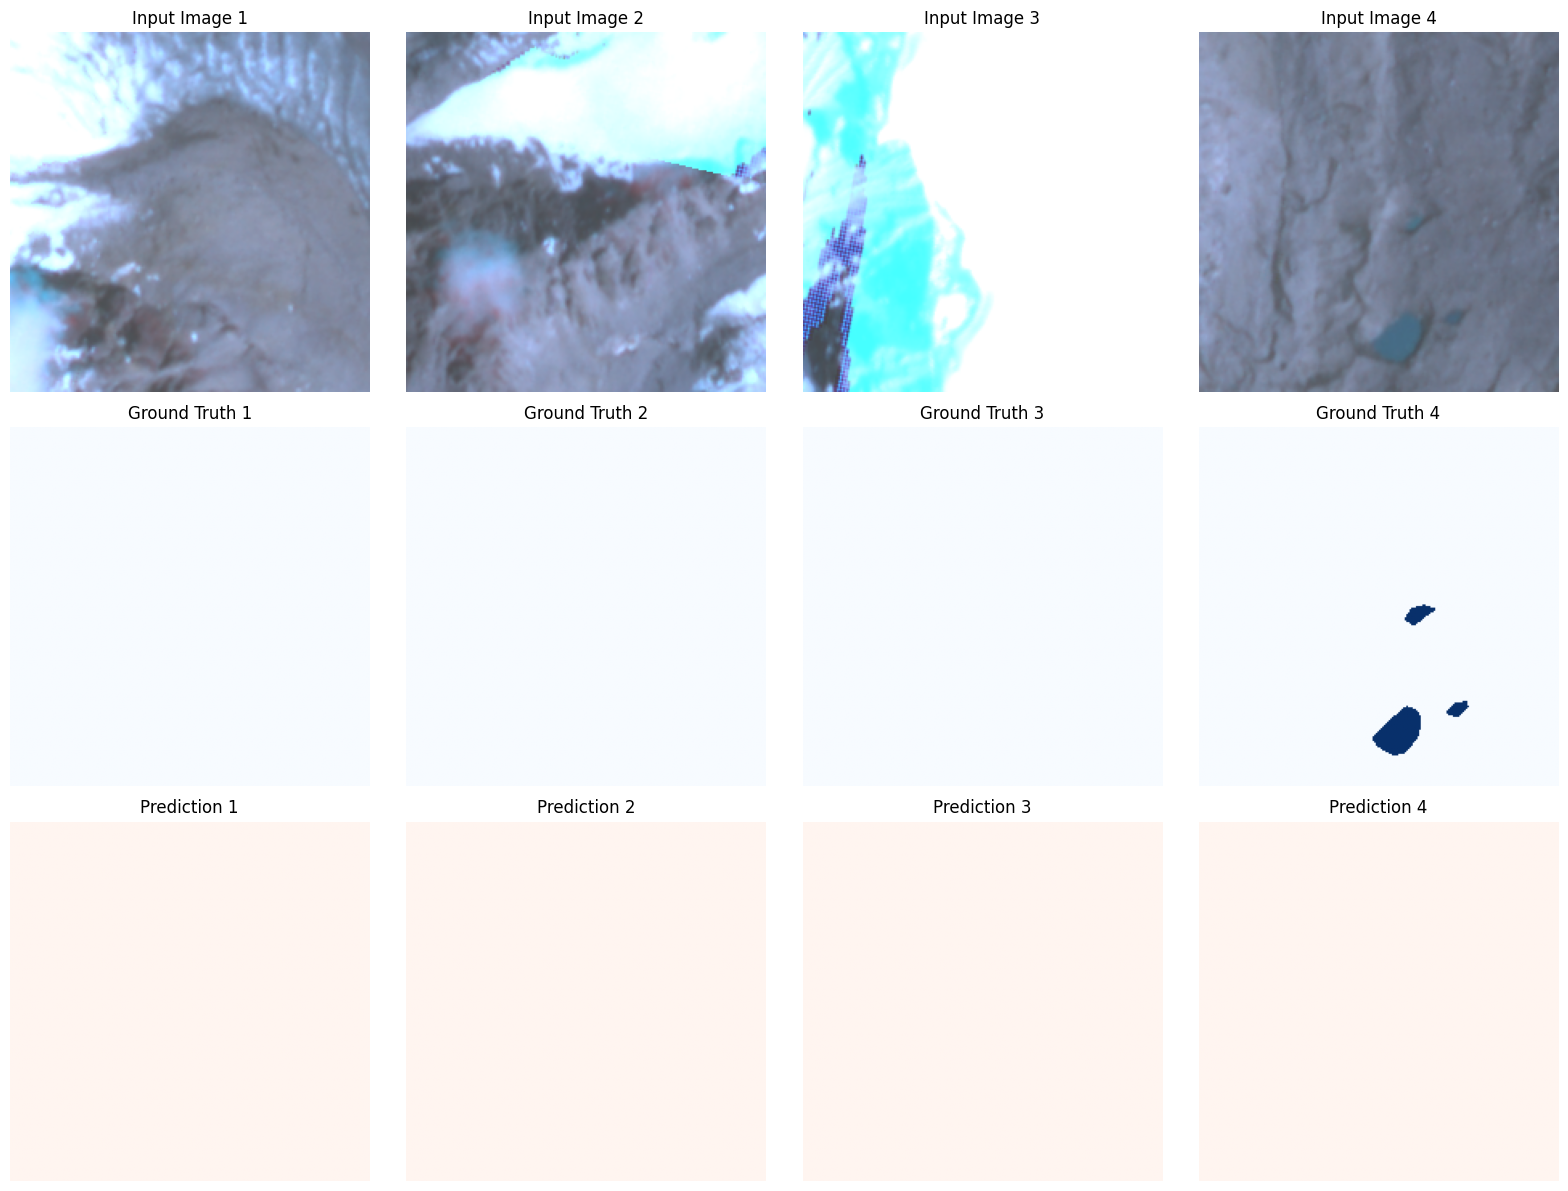


Model Performance:
IoU (Intersection over Union): 0.000
Pixel Accuracy: 0.996


In [18]:
# Test the model on a few examples
model.eval()

# Get a batch of test data
test_images, test_masks = next(iter(dataloader))
test_images = test_images.to(device)

# Generate predictions
with torch.no_grad():
    predicted_masks = model(test_images)

# Move to CPU for visualization
test_images = test_images.cpu()
test_masks = test_masks.cpu()
predicted_masks = predicted_masks.cpu()

# Visualize results
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for i in range(min(4, len(test_images))):
    # Original image (denormalize for display)
    img = test_images[i].permute(1, 2, 0)
    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    img = torch.clamp(img, 0, 1)
    
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Input Image {i+1}')
    axes[0, i].axis('off')
    
    # Ground truth mask
    axes[1, i].imshow(test_masks[i].squeeze(), cmap='Blues')
    axes[1, i].set_title(f'Ground Truth {i+1}')
    axes[1, i].axis('off')
    
    # Predicted mask
    pred_mask = predicted_masks[i].squeeze()
    axes[2, i].imshow(pred_mask, cmap='Reds')
    axes[2, i].set_title(f'Prediction {i+1}')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

# Calculate accuracy metrics
def calculate_metrics(pred_masks, true_masks, threshold=0.5):
    pred_binary = (pred_masks > threshold).float()
    
    intersection = (pred_binary * true_masks).sum()
    union = pred_binary.sum() + true_masks.sum() - intersection
    
    iou = intersection / (union + 1e-8)
    accuracy = ((pred_binary == true_masks).float().mean())
    
    return iou.item(), accuracy.item()

iou, accuracy = calculate_metrics(predicted_masks, test_masks)
print(f"\nModel Performance:")
print(f"IoU (Intersection over Union): {iou:.3f}")
print(f"Pixel Accuracy: {accuracy:.3f}")

In [19]:
# Debug: Check the actual data before Step 7
print("=== DEBUGGING IMAGE DATA ===")
print(f"image_rgb type: {type(image_rgb)}")
print(f"image_rgb shape: {image_rgb.shape}")
print(f"image_rgb dtype: {image_rgb.dtype}")
print(f"image_rgb min/max: {image_rgb.min()}/{image_rgb.max()}")

print(f"mask_binary type: {type(mask_binary)}")
print(f"mask_binary shape: {mask_binary.shape}")
print(f"mask_binary dtype: {mask_binary.dtype}")
print(f"mask_binary min/max: {mask_binary.min()}/{mask_binary.max()}")

# Check if there are any invalid values
print(f"image_rgb has NaN: {np.isnan(image_rgb).any()}")
print(f"image_rgb has inf: {np.isinf(image_rgb).any()}")

# Show a small sample
print(f"image_rgb sample (top-left 3x3, channel 0): \n{image_rgb[:3, :3, 0]}")

# Test with just one 224x224 patch
test_patch = image_rgb[:224, :224, :3]  # Take only RGB channels
print(f"\nTest patch shape: {test_patch.shape}")
print(f"Test patch min/max: {test_patch.min()}/{test_patch.max()}")

print("=== DEBUG COMPLETE ===\n")

=== DEBUGGING IMAGE DATA ===
image_rgb type: <class 'numpy.ndarray'>
image_rgb shape: (4673, 1362, 3)
image_rgb dtype: uint8
image_rgb min/max: 70/255
mask_binary type: <class 'numpy.ndarray'>
mask_binary shape: (4673, 1362)
mask_binary dtype: float32
mask_binary min/max: 0.0/1.0
image_rgb has NaN: False
image_rgb has inf: False
image_rgb sample (top-left 3x3, channel 0): 
[[140 144 150]
 [139 140 146]
 [137 140 144]]

Test patch shape: (224, 224, 3)
Test patch min/max: 70/255
=== DEBUG COMPLETE ===



## Step 7: Apply to Full Image

Testing single patch prediction...
Test patch shape: (224, 224, 3)
Test mask shape: (224, 224)
DINOv3 features shape: torch.Size([1, 201, 768])
After removing CLS token: torch.Size([1, 200, 768])
Using spatial dimensions: 10x20 = 200 patches (target: 200)
Final feature map shape: torch.Size([1, 768, 10, 20])
Decoder input shape: torch.Size([1, 768, 10, 20])
Before final resize: torch.Size([1, 1, 10, 20])
After final resize: torch.Size([1, 1, 224, 224])
Final output mask shape: torch.Size([1, 1, 224, 224])
Prediction successful! Shape: (224, 224)


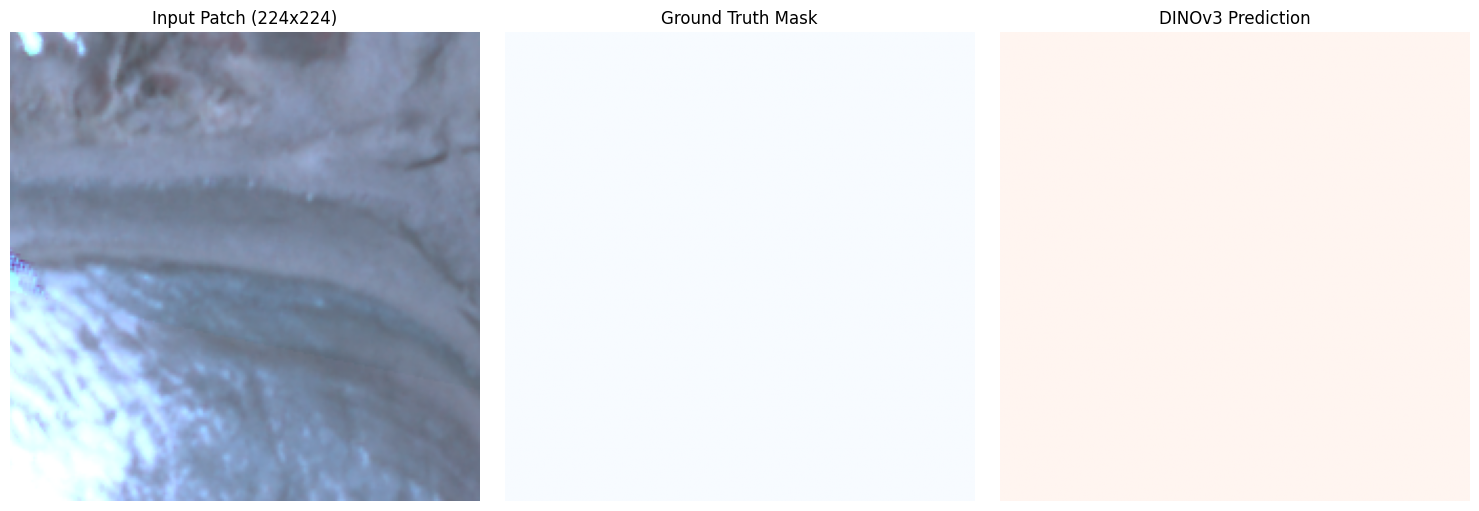


Single Patch Results:
IoU: 0.000
Water pixels detected: 0
Actual water pixels: 0.0

Single patch test completed!


In [20]:
def predict_single_patch(model, image_patch):
    """
    Simple function to predict on a single 224x224 patch
    """
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Ensure patch is exactly 224x224x3
    if image_patch.shape[:2] != (224, 224):
        # Pad or crop to 224x224
        padded_patch = np.zeros((224, 224, 3), dtype=image_patch.dtype)
        h, w = image_patch.shape[:2]
        copy_h = min(h, 224)
        copy_w = min(w, 224)
        padded_patch[:copy_h, :copy_w] = image_patch[:copy_h, :copy_w, :3]
        image_patch = padded_patch
    
    # Transform and predict
    patch_tensor = transform(image_patch).unsqueeze(0).to(device)
    
    with torch.no_grad():
        pred_mask = model(patch_tensor).squeeze().cpu().numpy()
    
    return pred_mask

# Test with a simple single patch first
print("Testing single patch prediction...")

# Take a 224x224 patch from the image
test_patch = image_rgb[:224, :224, :3]  # Ensure only RGB channels
test_mask = mask_binary[:224, :224]

print(f"Test patch shape: {test_patch.shape}")
print(f"Test mask shape: {test_mask.shape}")

try:
    # Predict on single patch
    predicted_patch = predict_single_patch(model, test_patch)
    print(f"Prediction successful! Shape: {predicted_patch.shape}")
    
    # Visualize single patch result
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(test_patch)
    axes[0].set_title('Input Patch (224x224)')
    axes[0].axis('off')
    
    axes[1].imshow(test_mask, cmap='Blues')
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')
    
    axes[2].imshow(predicted_patch, cmap='Reds')
    axes[2].set_title('DINOv3 Prediction')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate simple metrics
    pred_binary = (predicted_patch > 0.5).astype(float)
    intersection = (pred_binary * test_mask).sum()
    union = pred_binary.sum() + test_mask.sum() - intersection
    iou = intersection / (union + 1e-8)
    
    print(f"\nSingle Patch Results:")
    print(f"IoU: {iou:.3f}")
    print(f"Water pixels detected: {(predicted_patch > 0.5).sum()}")
    print(f"Actual water pixels: {test_mask.sum()}")
    
except Exception as e:
    print(f"Error in single patch prediction: {e}")
    import traceback
    traceback.print_exc()

print("\nSingle patch test completed!")

Applying model to full image...
DINOv3 features shape: torch.Size([1, 201, 768])
After removing CLS token: torch.Size([1, 200, 768])
Using spatial dimensions: 10x20 = 200 patches (target: 200)
Final feature map shape: torch.Size([1, 768, 10, 20])
Decoder input shape: torch.Size([1, 768, 10, 20])
Before final resize: torch.Size([1, 1, 10, 20])
After final resize: torch.Size([1, 1, 224, 224])
Final output mask shape: torch.Size([1, 1, 224, 224])
DINOv3 features shape: torch.Size([1, 201, 768])
After removing CLS token: torch.Size([1, 200, 768])
Using spatial dimensions: 10x20 = 200 patches (target: 200)
Final feature map shape: torch.Size([1, 768, 10, 20])
Decoder input shape: torch.Size([1, 768, 10, 20])
Before final resize: torch.Size([1, 1, 10, 20])
After final resize: torch.Size([1, 1, 224, 224])
Final output mask shape: torch.Size([1, 1, 224, 224])
DINOv3 features shape: torch.Size([1, 201, 768])
After removing CLS token: torch.Size([1, 200, 768])
Using spatial dimensions: 10x20 = 2

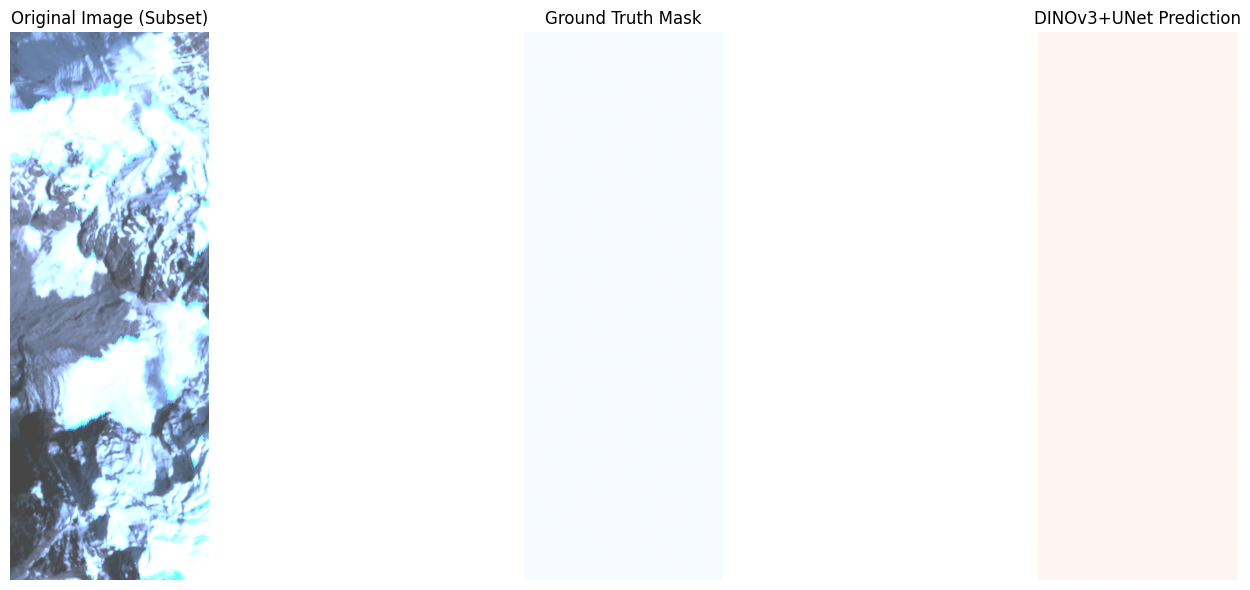


Pixel-level segmentation complete!
This approach gives you precise lake boundaries, not just patch-level predictions.


In [21]:
def predict_full_image(model, image, patch_size=224, stride=112):
    """
    Apply the trained model to a full large image using sliding window
    """
    model.eval()
    height, width = image.shape[:2]
    
    # Create output mask
    full_mask = np.zeros((height, width), dtype=np.float32)
    count_mask = np.zeros((height, width), dtype=np.float32)
    
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    print("Applying model to full image...")
    
    patches_processed = 0
    with torch.no_grad():
        for y in range(0, height - patch_size + 1, stride):
            for x in range(0, width - patch_size + 1, stride):
                # Extract patch
                patch = image[y:y+patch_size, x:x+patch_size]
                
                # Transform and predict
                patch_tensor = transform(patch).unsqueeze(0).to(device)
                pred_mask = model(patch_tensor).squeeze().cpu().numpy()
                
                # Add to full mask
                full_mask[y:y+patch_size, x:x+patch_size] += pred_mask
                count_mask[y:y+patch_size, x:x+patch_size] += 1
                
                patches_processed += 1
                if patches_processed % 20 == 0:
                    print(f"  Processed {patches_processed} patches...")
    
    # Average overlapping predictions
    full_mask = np.divide(full_mask, count_mask, out=np.zeros_like(full_mask), where=count_mask!=0)
    
    return full_mask

# Apply to a smaller region first (full image might be too large)
# Take a 1000x1000 subset for demonstration
subset_size = 1000
y_start, x_start = 1000, 1000  # Adjust these coordinates
image_subset = image_rgb[y_start:y_start+subset_size, x_start:x_start+subset_size]
mask_subset = mask_binary[y_start:y_start+subset_size, x_start:x_start+subset_size]

# Predict on subset
predicted_full_mask = predict_full_image(model, image_subset, patch_size=224, stride=112)

# Visualize full prediction
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(image_subset)
axes[0].set_title('Original Image (Subset)')
axes[0].axis('off')

axes[1].imshow(mask_subset, cmap='Blues')
axes[1].set_title('Ground Truth Mask')
axes[1].axis('off')

axes[2].imshow(predicted_full_mask, cmap='Reds')
axes[2].set_title('DINOv3+UNet Prediction')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("\nPixel-level segmentation complete!")
print("This approach gives you precise lake boundaries, not just patch-level predictions.")

## Summary

**What this notebook achieved:**

1. **True pixel-level segmentation** - each pixel gets classified as lake/not lake
2. **DINOv3 features** - powerful satellite-trained representations 
3. **U-Net decoder** - specialized for precise boundary detection
4. **Training on your data** - learns from your manual lake masks

**Key advantages over patch classification:**
- Precise lake boundaries (not rectangular patches)
- Pixel-level accuracy
- Better for tracking lake changes over time
- Scalable to any image size

**Next steps:**
- Train on more data for better accuracy
- Apply to multiple time periods to track changes
- Fine-tune hyperparameters
- Use larger DINOv3 models for better features

Generating full image prediction...
Using 800x800 subset for visualization
DINOv3 features shape: torch.Size([1, 201, 768])
After removing CLS token: torch.Size([1, 200, 768])
Using spatial dimensions: 10x20 = 200 patches (target: 200)
Final feature map shape: torch.Size([1, 768, 10, 20])
Decoder input shape: torch.Size([1, 768, 10, 20])
Before final resize: torch.Size([1, 1, 10, 20])
After final resize: torch.Size([1, 1, 224, 224])
Final output mask shape: torch.Size([1, 1, 224, 224])
DINOv3 features shape: torch.Size([1, 201, 768])
After removing CLS token: torch.Size([1, 200, 768])
Using spatial dimensions: 10x20 = 200 patches (target: 200)
Final feature map shape: torch.Size([1, 768, 10, 20])
Decoder input shape: torch.Size([1, 768, 10, 20])
Before final resize: torch.Size([1, 1, 10, 20])
After final resize: torch.Size([1, 1, 224, 224])
Final output mask shape: torch.Size([1, 1, 224, 224])
DINOv3 features shape: torch.Size([1, 201, 768])
After removing CLS token: torch.Size([1, 200

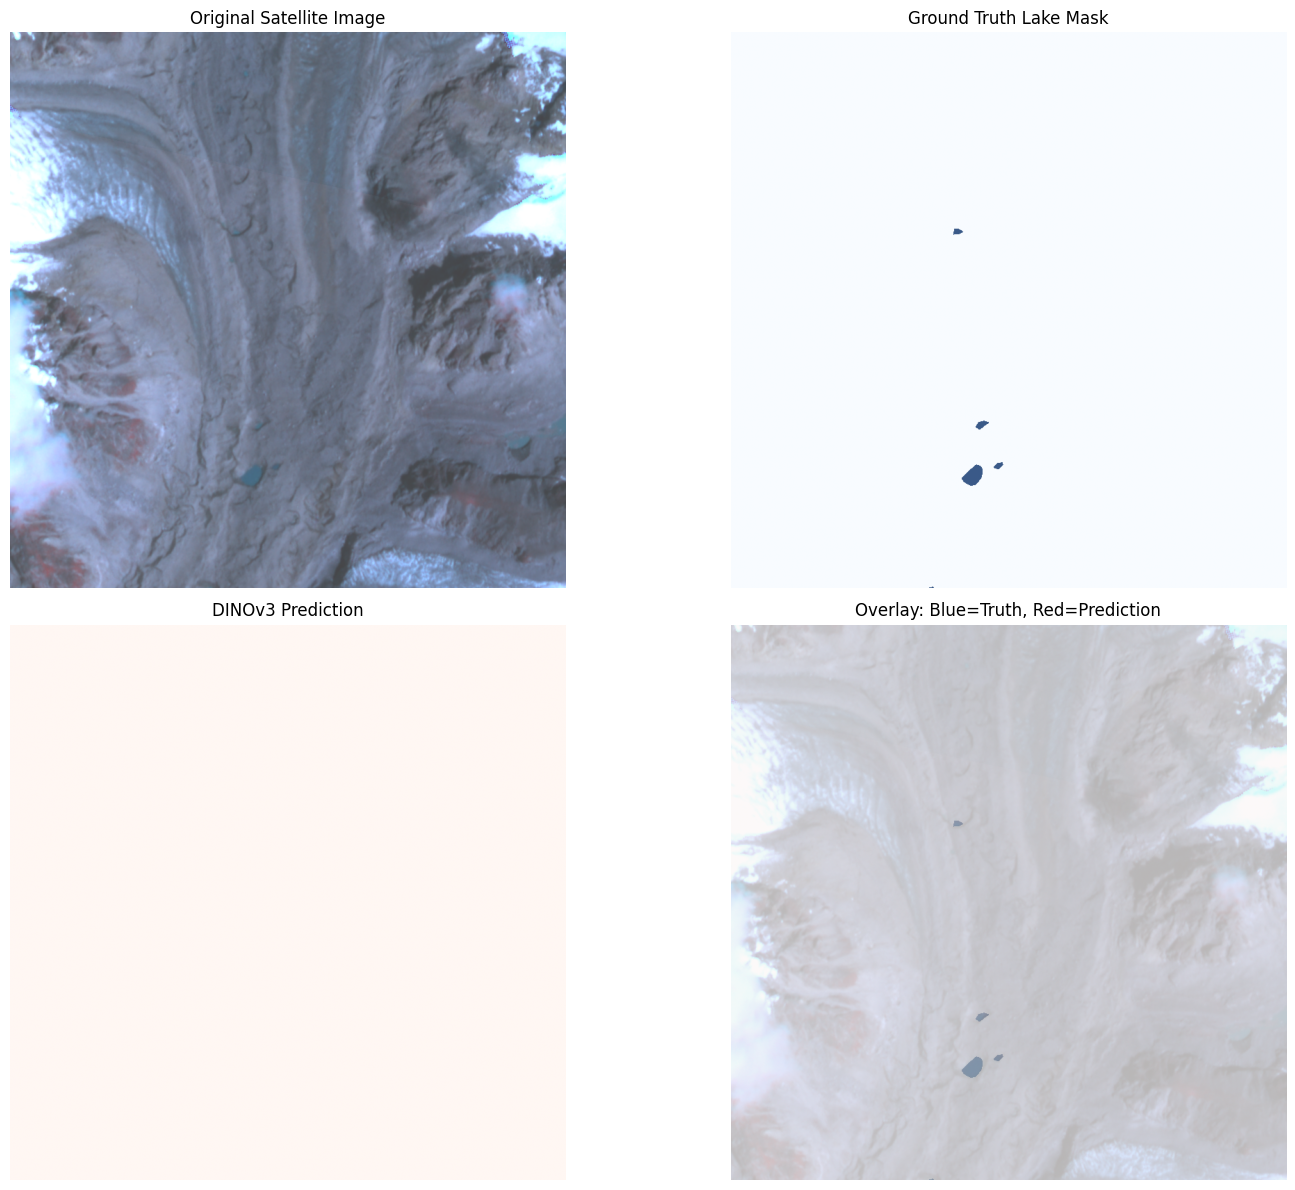


Full Image Results:
IoU (Intersection over Union): 0.000
Pixel Accuracy: 0.999
True lake pixels: 904
Predicted lake pixels: 0


In [23]:
def visualize_final_prediction(model, image, mask, patch_size=224, stride=112, max_size=800):
  """
  Visualize the final full-image prediction vs ground truth
  """
  print("Generating full image prediction...")

  # Use subset if image is too large
  height, width = image.shape[:2]
  if height > max_size or width > max_size:
      h_crop = min(height, max_size)
      w_crop = min(width, max_size)
      image_crop = image[:h_crop, :w_crop]
      mask_crop = mask[:h_crop, :w_crop]
      print(f"Using {h_crop}x{w_crop} subset for visualization")
  else:
      image_crop = image
      mask_crop = mask

  # Generate prediction using sliding window
  model.eval()
  height, width = image_crop.shape[:2]

  full_mask = np.zeros((height, width), dtype=np.float32)
  count_mask = np.zeros((height, width), dtype=np.float32)

  transform = transforms.Compose([
      transforms.ToPILImage(),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

  patches_processed = 0
  with torch.no_grad():
      for y in range(0, height - patch_size + 1, stride):
          for x in range(0, width - patch_size + 1, stride):
              # Extract patch (only RGB channels)
              patch = image_crop[y:y+patch_size, x:x+patch_size, :3]

              # Predict
              patch_tensor = transform(patch).unsqueeze(0).to(device)
              pred_mask = model(patch_tensor).squeeze().cpu().numpy()

              # Add to full mask
              full_mask[y:y+patch_size, x:x+patch_size] += pred_mask
              count_mask[y:y+patch_size, x:x+patch_size] += 1

              patches_processed += 1

  # Average overlapping predictions
  predicted_mask = np.divide(full_mask, count_mask, out=np.zeros_like(full_mask), where=count_mask!=0)

  print(f"Processed {patches_processed} patches")

  # Create visualization
  fig, axes = plt.subplots(2, 2, figsize=(16, 12))

  # Original image
  axes[0, 0].imshow(image_crop)
  axes[0, 0].set_title('Original Satellite Image')
  axes[0, 0].axis('off')

  # Ground truth mask
  axes[0, 1].imshow(mask_crop, cmap='Blues', alpha=0.8)
  axes[0, 1].set_title('Ground Truth Lake Mask')
  axes[0, 1].axis('off')

  # DINOv3 prediction
  axes[1, 0].imshow(predicted_mask, cmap='Reds', alpha=0.8)
  axes[1, 0].set_title('DINOv3 Prediction')
  axes[1, 0].axis('off')

  # Overlay comparison
  axes[1, 1].imshow(image_crop)
  axes[1, 1].imshow(mask_crop, cmap='Blues', alpha=0.4, label='Ground Truth')
  axes[1, 1].imshow(predicted_mask > 0.5, cmap='Reds', alpha=0.4, label='Prediction')
  axes[1, 1].set_title('Overlay: Blue=Truth, Red=Prediction')
  axes[1, 1].axis('off')

  plt.tight_layout()
  plt.show()

  # Calculate metrics
  pred_binary = (predicted_mask > 0.5).astype(float)
  true_binary = (mask_crop > 0).astype(float)

  intersection = (pred_binary * true_binary).sum()
  union = pred_binary.sum() + true_binary.sum() - intersection
  iou = intersection / (union + 1e-8)

  accuracy = ((pred_binary == true_binary).sum()) / (pred_binary.size)

  print(f"\nFull Image Results:")
  print(f"IoU (Intersection over Union): {iou:.3f}")
  print(f"Pixel Accuracy: {accuracy:.3f}")
  print(f"True lake pixels: {true_binary.sum():.0f}")
  print(f"Predicted lake pixels: {pred_binary.sum():.0f}")

  return predicted_mask

# Generate and visualize final prediction
final_prediction = visualize_final_prediction(model, image_rgb, mask_binary, patch_size=224, stride=112)